Kaggle Competition: House Prices

Project Team: Jason Harville, Dan Wald, Andrea Pope

## Prep and Helper Functions

In [1]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# general libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from numpy import *
import math

# functions to clean data, see external .py file
from data_funcs import *


#sklearn libraries
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_predict
from sklearn.decomposition import PCA


/Users/dan/anaconda/envs/py27/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [2]:
# A function to calculate Root Mean Squared Logarithmic Error (RMSLE)
# Measurement used by Kaggle to Score the Competition
def rmsle(y, y_pred):
    assert len(y) == len(y_pred)
    terms_to_sum = [(math.log(y_pred[i] + 1) - math.log(y[i] + 1)) ** 2.0 for i,pred in enumerate(y_pred)]
    return (sum(terms_to_sum) * (1.0/len(y))) ** 0.5

## Data Cleansing and Prep

The data available was divided into 3 main types of data:
1. Categorical: divided into dummy variables representing each sub-category
2. Continuous: numerical data
3. Likert scale: ratings converted to numerical scale

After the raw processing of each data type, mean normlization was conducted to ensure no feature had undue weight in comparison to another feature.

Additionally, 5 features were excluded due to insignificant population or information similar to all variables.

In [3]:
# we initially split the training file into a train and dev file;

# after shuffling the training file was split, the split versions were exported into .csv files
# to ensure consistent work/results across team members and via iterations

train = pd.read_csv('./data/train_split.csv')
dev = pd.read_csv('./data/dev_split.csv')

In [4]:
# Variables for processing
normal_cat_features = ['MSZoning','LandContour','LotShape','LotConfig','LandSlope','Neighborhood','BldgType','HouseStyle','RoofStyle','MasVnrType',
                       'Foundation','Heating','Electrical','Functional','GarageType','GarageFinish','PavedDrive',
                       'Fence','MiscFeature','SaleType','SaleCondition']

special_cat_features = ['CentralAir','Condition1','Condition2','Exterior1st','Exterior2nd','BsmtFinType1','BsmtFinType2']

used_cat_features = normal_cat_features + special_cat_features

drop_features = ['MSSubClass','Street','Alley','Utilities','RoofMatl']
drop_dummies = ['MSZoning_C (all)','LotShape_Reg','LotShape_IR1','LotShape_IR2','LotShape_IR3','LotConfig_FR2','LotConfig_FR3']

feature_dict = get_train_cat_features(train_data=train, used_cat_features=used_cat_features)

likert_features = ['ExterQual','ExterCond','BsmtQual','BsmtCond','BsmtExposure','HeatingQC','KitchenQual',
                   'FireplaceQu','GarageQual','GarageCond','PoolQC']

# Getting labels and data
train_labels = train['SalePrice']
dev_labels = dev['SalePrice']

keep_columns = [col for col in train.columns if col not in ['Unnamed: 0', 'SalePrice', 'Id']]
train_data = train.set_index('Id')[keep_columns]
dev_data = dev.set_index('Id')[keep_columns]

#transforming features
train_data = transform_features(train_data,feature_dict,normal_cat_features,used_cat_features,
                                likert_features,drop_dummies,drop_features)
dev_data = transform_features(dev_data,feature_dict,normal_cat_features,used_cat_features,
                              likert_features,drop_dummies,drop_features)

# Mean normalizing
features_to_normalize = train_data.columns
mn_values = {value: find_mu_std(train_data, value) for value in features_to_normalize}

train_data = mean_normalization(train_data, features_to_normalize, mn_values)
dev_data = mean_normalization(dev_data, features_to_normalize, mn_values)

In [5]:
def make_heat(correlation_df):
    # Set up the matplotlib figure
    #import matplotlib.pyplot as plt
#    f, ax = plt.subplots(figsize=(12, 9))
    f, ax = plt.subplots()


    #apply mask
    mask = np.zeros_like(correlation_df)
    mask[np.triu_indices_from(mask)] = True
    
    # Draw the heatmap using seaborn and minimize ink
    with sns.axes_style("white"):
        ax = sns.heatmap(correlation_df, mask=mask, vmax=.3, square=False)

#make_heat(indexed_corr) debugging only

In [6]:
train_cor = train_data.corr()

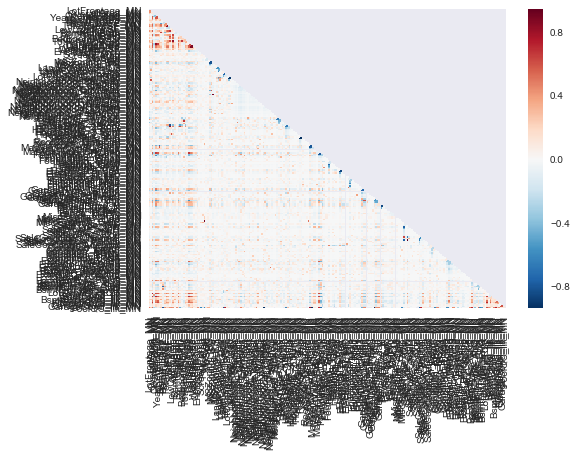

In [7]:
make_heat(train_cor)

TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

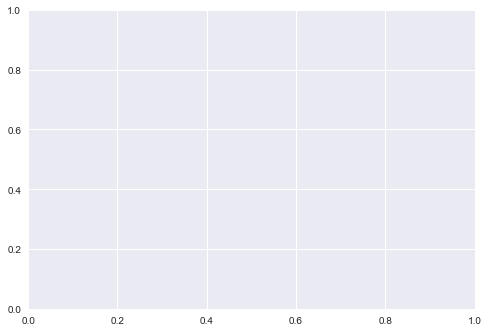

In [19]:
make_heat(train)

In [7]:
print len(normal_cat_features)
print len(special_cat_features)
print len(likert_features)
print len(drop_features) + len(drop_dummies)

21
7
11
12


In [5]:
# final conversion of cleansed data for use in regression
# convert to np arrays
train_data = np.array(train_data)
dev_data = np.array(dev_data)
type(train_data)

# deal with NaNs (which won't work in regression)
where_are_NaNs = isnan(train_data)
train_data[where_are_NaNs] = 0

where_are_NaNs = isnan(dev_data)
dev_data[where_are_NaNs] = 0



## Baseline Regression

Initial regression conducted on just cleansed data, without any feature selection or consideration.

In [6]:
# using gradient descent to understand learning rate and cost components
# eta is the learning rate; smaller values will tend to give slower but more precise convergence.
# num_iters is the number of iterations to run.
def gradient_descent(train_data, target_data, eta, num_iters):
    # Add a 1 to each feature vector so we learn an intercept.
    X = np.c_[np.ones(train_data.shape[0]), train_data]
    #print("X: ", X)
    #print("X.T: ",X.T)
    
    # m = number of samples, k = number of features
    m, k = X.shape
    #print(m)
    #print(k)
    
    # Initially, set all the parameters to 1.
    theta = np.ones(k)
    #print(theta)
    
    # Keep track of costs after each step.
    costs = []
    
    for iter in range(0, num_iters):
        # Get the current predictions for the training examples given the current estimate of theta.
        hypothesis = np.dot(X, theta)
        #print("hypothesis: ", hypothesis)
        # The loss is the difference between the predictions and the actual target values.
        loss = hypothesis - target_data
        #print("loss: ", loss)
        # In standard linear regression, we want to minimize the sum of squared losses.
        cost = np.sum(loss ** 2) / (2 * m)
        costs.append(cost)
        #print("costs: ", costs)
        # Compute the gradient.
        #print("dot:", np.dot(X.T, loss))
        gradient = np.dot(X.T, loss) / m
        #print("gradient:", gradient)
        
        # Update theta, scaling the gradient by the learning rate.
        theta = theta - eta * gradient
        #print(theta)
        
    return theta, costs

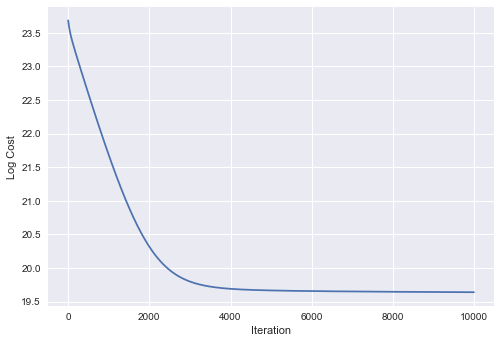

In [7]:
num_feats = 206
theta, costs = gradient_descent(train_data[:,0:num_feats], train_labels, .001,10000)
plt.plot(map(np.log, costs))
plt.xlabel('Iteration'), plt.ylabel('Log Cost')
plt.show()

In [8]:
# fit LR using SKLearn package
lr = LinearRegression(fit_intercept=True)
lr.fit(train_data, train_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [9]:
predictions = lr.predict(dev_data)
#print(type(predictions))

In [10]:
# convert any negative predictions to zero (enables log error scoring)
predictions[predictions < 0] = 0

In [11]:
# Explained variance score: 1 is perfect prediction
print('Variance score, Training: %.2f' % lr.score(train_data, train_labels))

print('Variance score, Dev: %.2f' % lr.score(dev_data, dev_labels))

print("Abs Mean Error - Train: %.2f"
      % np.mean(np.abs((lr.predict(train_data) - train_labels))))

#mean error
print("Abs Mean Error: %.2f"
      % np.mean(np.abs(predictions - dev_labels)))

# The mean squared error
print("Mean squared error: %.2f"
      % np.mean((predictions - dev_labels) ** 2))


#kaggle measure of success - root mean squared Logarithmic error
print("Root Mean Squared Logarithmic Error: %.2f"
      % rmsle(dev_labels, predictions))

Variance score, Training: 0.89
Variance score, Dev: 0.85
Abs Mean Error - Train: 16735.89
Abs Mean Error: 21813.39
Mean squared error: 1474074262.52
Root Mean Squared Logarithmic Error: 0.93


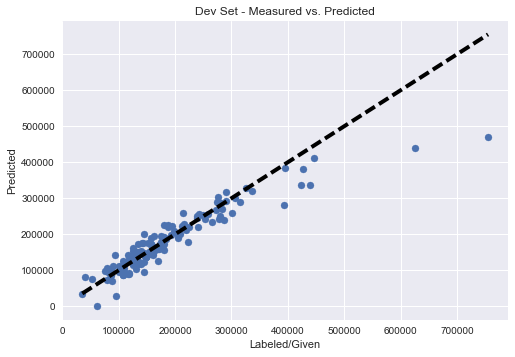

In [12]:
#using cross val predict to visualize prediction errors:

# cross_val_predict returns an array of the same size as `y` where each entry
# is a prediction obtained by cross validation:
predicted = cross_val_predict(lr, dev_data, dev_labels, cv=10)

fig, ax = plt.subplots()
ax.scatter(dev_labels, predictions)
ax.plot([dev_labels.min(), dev_labels.max()], [dev_labels.min(), dev_labels.max()], 'k--', lw=4)
ax.set_xlabel('Labeled/Given')
ax.set_ylabel('Predicted')
plt.title("Dev Set - Measured vs. Predicted")
plt.show()

## Initial Collinearity Handling, via PCA

In [13]:
# feature reduction using PCA (also handles collinearity (albeit blindly))
pca = PCA(n_components=10)
pca.fit(train_data)
# transform training and dev for testing results
train_data_pca = pca.transform(train_data)
dev_data_pca = pca.transform(dev_data)

## 2nd Regression

In [14]:
lr2 = LinearRegression(fit_intercept=True)

lr2.fit(train_data_pca, train_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [15]:
predictions = lr2.predict(dev_data_pca)

In [16]:
# Explained variance score: 1 is perfect prediction
print('Variance score, Training: %.2f' % lr2.score(train_data_pca, train_labels))

print('Variance score, Dev: %.2f' % lr2.score(dev_data_pca, dev_labels))

print("Abs Mean Error - Train: %.2f"
      % np.mean(np.abs((lr2.predict(train_data_pca) - train_labels))))

#mean error
print("Abs Mean Error: %.2f"
      % np.mean(np.abs(predictions - dev_labels)))

# The mean squared error
print("Mean squared error: %.2f"
      % np.mean((predictions - dev_labels) ** 2))

#kaggle measure of success - root mean squared logarithmic error
print("Root Mean Squared Logarithmic Error: %.2f"
      % rmsle(dev_labels, predictions))

Variance score, Training: 0.80
Variance score, Dev: 0.80
Abs Mean Error - Train: 21049.17
Abs Mean Error: 23439.66
Mean squared error: 1972702560.71
Root Mean Squared Logarithmic Error: 0.17


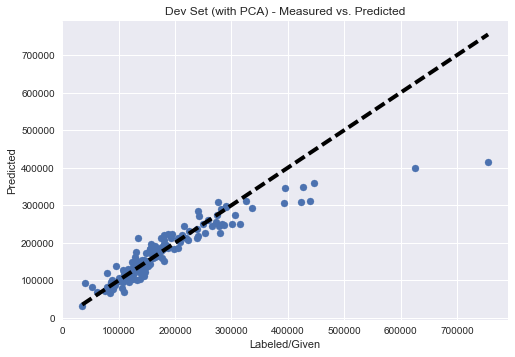

In [17]:
#using cross val predict to visualize prediction errors:

# cross_val_predict returns an array of the same size as `y` where each entry
# is a prediction obtained by cross validation:
predicted = cross_val_predict(lr2, dev_data_pca, dev_labels, cv=10)

fig, ax = plt.subplots()
ax.scatter(dev_labels, predictions)
ax.plot([dev_labels.min(), dev_labels.max()], [dev_labels.min(), dev_labels.max()], 'k--', lw=4)
ax.set_xlabel('Labeled/Given')
ax.set_ylabel('Predicted')
plt.title("Dev Set (with PCA) - Measured vs. Predicted")
plt.show()

Improvement in  Root Mean Squared Logarithmic Error (Kaggle Measure), but decrease in Variance and absolute mean error

We are off on our high-end properties; currently the model is not catching that

Future plans (not complete):
    L1 and L2 with and without PCA
    Binning Regression - determining high and low end models, and train model to use appropriate models